In [1]:
!pip install lightgbm

# Required Imports

In [43]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve, make_scorer
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV



# Loading Data

In [2]:
train_identity= pd.read_csv('train_identity.csv')
train_transaction= pd.read_csv('train_transaction.csv')

# Understanding the Data

In [3]:
train_identity.shape

(144233, 41)

In [4]:
train_transaction.shape

(590540, 394)

In [5]:
train_identity.sample(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
63965,3149201,-25.0,186458.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,mobile safari 11.0,NaN,NaN,NaN,F,F,F,T,mobile,NaN
118489,3448418,-5.0,392.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 65.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
19425,3044043,0.0,169216.0,0.0,0.0,2.0,0.0,NaN,NaN,0.0,...,chrome 60.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,LG-H542 Build/LRX22G
143797,3575181,-10.0,236941.0,0.0,0.0,4.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G950F Build/R16NW
5853,3009912,-5.0,31676.0,3.0,0.0,1.0,0.0,NaN,NaN,1.0,...,chrome 58.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
89839,3291366,-5.0,40186.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,safari generic,24.0,1440x900,match_status:2,T,F,T,F,desktop,MacOS
39163,3082663,-5.0,107558.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,...,chrome 63.0,24.0,1680x1050,match_status:2,T,F,T,F,desktop,Windows
136724,3541746,-5.0,99908.0,0.0,0.0,5.0,0.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1440,match_status:2,T,F,T,F,desktop,Windows
116542,3438400,-5.0,254460.0,0.0,0.0,0.0,-100.0,NaN,NaN,0.0,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G570M Build/MMB29K
67789,3173182,-5.0,89326.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,ie 11.0 for desktop,24.0,1600x900,match_status:2,T,F,T,T,desktop,Trident/7.0


In [6]:
train_transaction.sample(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
258448,3245448,0,6202674,47.950,W,12544,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48165,3035165,0,1134892,58.950,W,12598,111.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486527,3473527,0,12679163,107.950,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273157,3260157,0,6633497,500.000,S,8937,399.0,150.0,american express,150.0,...,0.0,0.0,5000.0,0.0,0.0,0.0,0.0,0.0,5000.0,0.0
186430,3173430,0,4145069,57.950,W,9680,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567231,3554231,0,15032943,43.970,W,17400,174.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489578,3476578,0,12767775,121.950,W,5690,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265080,3252080,0,6401235,44.107,C,3154,408.0,185.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229605,3216605,0,5438246,335.000,W,7585,553.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242514,3229514,0,5760797,774.000,W,11660,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#checking for duplicate rows
train_transaction.duplicated().sum()

np.int64(0)

In [8]:
#checking for columns with null values
train_transaction.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

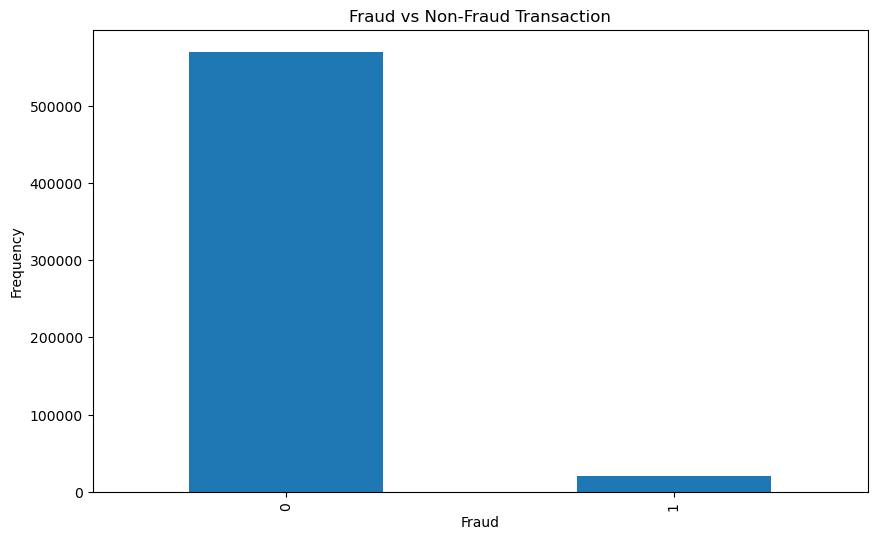

In [61]:
#checking for data imbalance in the target

fraud_count= train_transaction['isFraud'].value_counts()

plt.figure(figsize=(10,6))
fraud_count.plot(kind="bar")
plt.title('Fraud vs Non-Fraud Transaction')
plt.xlabel('Fraud')
plt.ylabel('Frequency')
plt.show()

This graph suggests that there is high imbalance in the data

In [62]:
train_transaction["TransactionDT"].describe()

count    5.905400e+05
mean     7.372311e+06
std      4.617224e+06
min      8.640000e+04
25%      3.027058e+06
50%      7.306528e+06
75%      1.124662e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64

In [9]:
#TransactionDT is in seconds, creating a new column from it, that tells the transaction day
train_transaction['transaction_day']= train_transaction['TransactionDT']//(24*60*60)

In [10]:
fraud_rate_by_day = train_transaction.groupby('transaction_day')['isFraud'].mean()

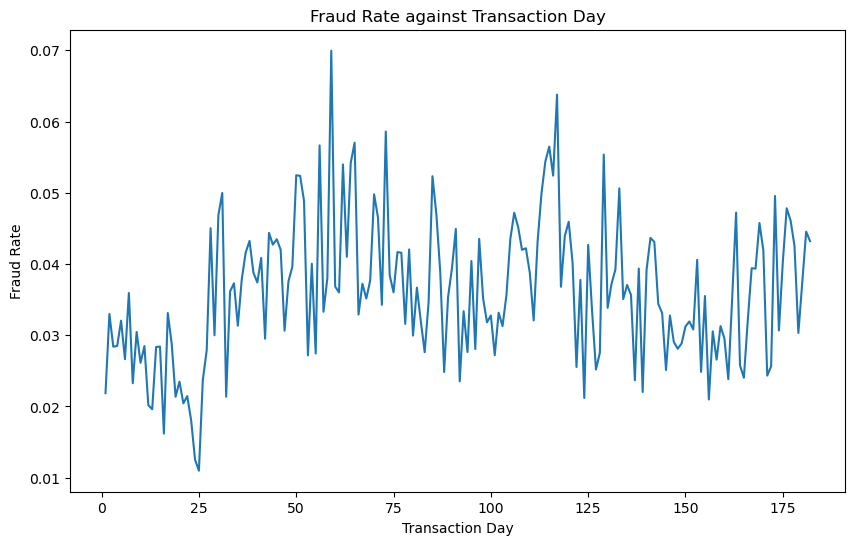

In [65]:
#Plotting the Fraud Rate against Transaction day

plt.figure(figsize=(10,6))
fraud_rate_by_day.plot()
plt.title('Fraud Rate against Transaction Day')
plt.xlabel('Transaction Day')
plt.ylabel('Fraud Rate')
plt.show()

In [11]:
#Merging identity data with transaction

data =train_transaction.merge(train_identity, on='TransactionID', how='left')

In [12]:
data.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#checking if there is any device info available
data['identity']= data['DeviceType'].notnull().astype(int)

In [14]:
data.groupby('identity')['isFraud'].mean()

identity
0    0.021017
1    0.079618
Name: isFraud, dtype: float64

## Insights

Dataset Overview
The dataset contains approximately 590K transactions with 394 features, consisting primarily of numerical variables with a small number of high-cardinality categorical features. Memory usage exceeds 1.7 GB, indicating the need for efficient data handling and modeling approaches.

Class Imbalance
Fraudulent transactions represent a small minority of the data, confirming a highly imbalanced classification problem. As a result, accuracy is not an appropriate evaluation metric, and precision-recall based metrics will be prioritized.

Temporal Behavior
Fraud rates exhibit significant variation over time, with clear spikes and drops across transaction days. This non-stationary behavior indicates evolving fraud patterns and confirms the need for time-based train/validation splits to avoid data leakage and better simulate real-world deployment.

Missing Values
A large proportion of features contain missing values, which is expected in fraud detection systems where signals are conditionally available. Missingness itself is potentially informative and will be handled implicitly by tree-based models rather than aggressive imputation during EDA.

Identity Data Impact
Transactions associated with identity information show a substantially higher fraud rate compared to those without identity data. This demonstrates that identity-related features and their missingness patterns provide meaningful predictive signal and should be incorporated into the modeling pipeline.


## Feature Engineering

In [15]:
#Splitting data into train and val, this data will be split on time-basis, so first 80% transactions will be included in train and rest 20% in validation
max_day= data['transaction_day'].max()

split_day= int(max_day*0.8)


In [16]:

train_data= data[data['transaction_day']<=split_day]
val_data = data[data['transaction_day']>split_day]

In [17]:
#Segregating data into features and label

target='isFraud'

excluded_col= [target, 'TransactionID','TransactionDT']

features= [ col for col in data
            if col not in excluded_col
            and data[col].dtype!=object]

X_train= train_data[features]
X_val= val_data[features]

y_train=train_data[target]
y_val=val_data[target]

# Modelling

In [18]:
#Creating a Lightgbm model 
model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 17052, number of negative: 467795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.604404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33692
[LightGBM] [Info] Number of data points in the train set: 484847, number of used features: 401
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,'binary'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# Evaluating the model

In [19]:
val_preds= model.predict_proba(X_val)[:,1]
pr_auc= average_precision_score(y_val, val_preds)
pr_auc

0.5213634132295334

In [20]:
precision, recall, threshold = precision_recall_curve(y_val, val_preds)

target_precision=0.90

valid=precision>=target_precision

max_recall= recall[valid].max()

max_recall

np.float64(0.2301301578510108)

# Improving the Model

In [21]:
#Temporal Feature Aggregation

data= data.sort_values(['card1','TransactionDT']).reset_index(drop=True)

In [22]:
#Checking how many transactions have taken place in last hour
seconds_in_hour= 60*60

data['txn_in_1hr']= (
    data.groupby("card1")['TransactionDT']
    .transform(
        lambda x:(
        x.shift(1)
        .rolling(window=seconds_in_hour, min_periods=1)
        .count()
        )
    )
)


In [23]:
#Mean transactions in the last 24 hours

seconds_in_days= 24*60*60

data['txn_in_1day']=(
    data.groupby('card1')['TransactionDT']
    .transform(
        lambda x: (
            x.shift(1)
            .rolling(window=seconds_in_days, min_periods=1)
            .mean()
        )
    )
)

In [24]:
# Transaction frequency acceleration
data['txn_acceleration_1hr'] = (
    data.groupby('card1')['TransactionDT']
    .transform(lambda x: x.diff().rolling(window=3600, min_periods=1).mean())
)

# Ratio features 
data['txn_ratio_1hr_1day'] = (
    data['txn_in_1hr'] / (data['txn_in_1day'] + 1)  # +1 to avoid division by zero
)

# Max amount relative to historical average
data['amt_vs_historical_max'] = (
    data['TransactionAmt'] / 
    (data.groupby('card1')['TransactionAmt']
     .shift(1).rolling(window=86400, min_periods=1).max() + 0.01)
)

In [25]:
# Card + Address combination (catches card testing at new addresses)
data['card_addr_txn_count'] = (
    data.groupby(['card1', 'addr1'])['TransactionID'].transform('count')
)

# Card + Email combination
data['card_email_txn_count'] = (
    data.groupby(['card1', 'P_emaildomain'])['TransactionID'].transform('count')
)



In [26]:
keep_temporal = [
    'card_addr_txn_count',
    'card_email_txn_count',
    'txn_acceleration_1hr',
    'txn_ratio_1hr_1day',
    'amt_vs_historical_max'
]

In [27]:

train_data= data[data['transaction_day']<=split_day]
val_data = data[data['transaction_day']>split_day]

In [28]:
base_features = [
    col for col in train_data.columns
    if col not in ['isFraud', 'TransactionDT', 'TransactionID']
    and train_data[col].dtype != 'object'
]

features = base_features + keep_temporal
features = list(dict.fromkeys(features))


In [29]:
features

['TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',


In [30]:
X_train= train_data[features]
X_val = val_data[features]

In [31]:
y_train= train_data[target]
y_val = val_data[target]

In [32]:
fraud_ratio= y_train.value_counts()[0] / y_train.value_counts()[1]

In [38]:
# Determine the probability threshold that maintains a minimum precision of 90% and yields the highest possible recall on the validation set

precision, recall, thresholds = precision_recall_curve(y_val, val_preds)

target_precision = 0.9

candidates = []

for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
    if p >= target_precision:
        candidates.append((t, r))

if len(candidates) == 0:
    raise ValueError("No threshold meets the target precision")

best_threshold, best_recall = max(candidates, key=lambda x: x[1])

best_threshold, best_recall


(np.float64(0.9833534932460725), np.float64(0.21268346718360565))

In [34]:
# Re-training the model to check if temporal aggregations have impacted its performance positively

updated_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=64,
    scale_pos_weight=fraud_ratio,
    random_state=42,
    n_jobs=-1
)

updated_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 17052, number of negative: 467795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.971868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35451
[LightGBM] [Info] Number of data points in the train set: 484847, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035170 -> initscore=-3.311763
[LightGBM] [Info] Start training from score -3.311763


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [35]:
val_preds = updated_model.predict_proba(X_val)[:, 1]


In [36]:
pr_auc = average_precision_score(y_val, val_preds)
pr_auc

0.5235358025269917

In [39]:
y_pred = (val_preds >= best_threshold).astype(int)

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

cm = confusion_matrix(y_val, y_pred)

precision, recall, cm

(0.9003516998827668,
 0.21268346718360565,
 array([[101997,     85],
        [  2843,    768]]))

# HyperParameter Tuning

In [40]:
tscv = TimeSeriesSplit(n_splits=2)

In [41]:
#Parameter list for Hyperparameter Tuning
param_dist = {
    "scale_pos_weight": [
        fraud_ratio * 0.5,
        fraud_ratio,
        fraud_ratio * 2
    ],
    "min_child_samples": [5, 10, 20],
    "lambda_l1": [0, 1],
    "lambda_l2": [0, 5]
}


In [42]:

base_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=64,
    objective="binary",
    random_state=42,
    n_jobs=1
)

In [46]:
#Applying RandomSearchCV

pr_auc_scorer = make_scorer(
    average_precision_score,
    needs_proba=True
)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=10,                
    scoring=pr_auc_scorer,
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=1,
    error_score=0
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.967619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> initscore=-3.267123
[LightGBM] [Info] Start training f

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=5, min_child_samples=20, scale_pos_weight=54.866877785597; total time=  50.9s
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.432785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> init

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=5, min_child_samples=20, scale_pos_weight=54.866877785597; total time= 1.2min
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.719792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> inits

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=5, min_child_samples=10, scale_pos_weight=27.4334388927985; total time=  49.2s
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.183356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> ini

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=5, min_child_samples=10, scale_pos_weight=27.4334388927985; total time= 1.2min
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.646203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> init

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=0, min_child_samples=20, scale_pos_weight=54.866877785597; total time=  50.0s
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.259358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> init

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=0, min_child_samples=20, scale_pos_weight=54.866877785597; total time= 1.2min
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.724261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> inits

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=5, min_child_samples=10, scale_pos_weight=13.71671944639925; total time=  49.8s
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.407562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> in

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=5, min_child_samples=10, scale_pos_weight=13.71671944639925; total time= 1.2min
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.692642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> ini

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=5, min_child_samples=20, scale_pos_weight=27.4334388927985; total time=  47.9s
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.245370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> ini

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=5, min_child_samples=20, scale_pos_weight=27.4334388927985; total time= 1.2min
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.757044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> init

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=5, min_child_samples=10, scale_pos_weight=27.4334388927985; total time=  55.9s
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.320012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> ini

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=5, min_child_samples=10, scale_pos_weight=27.4334388927985; total time= 1.4min
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.872518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> init

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=0, min_child_samples=10, scale_pos_weight=13.71671944639925; total time=  50.5s
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.337481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> in

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=1, lambda_l2=0, min_child_samples=10, scale_pos_weight=13.71671944639925; total time= 1.3min
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.924184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> ini

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=5, min_child_samples=10, scale_pos_weight=13.71671944639925; total time=  54.8s
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.575154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> in

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=5, min_child_samples=10, scale_pos_weight=13.71671944639925; total time= 1.3min
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.646564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> ini

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=0, min_child_samples=20, scale_pos_weight=54.866877785597; total time=  51.2s
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.395292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> init

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=0, min_child_samples=20, scale_pos_weight=54.866877785597; total time= 1.3min
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 5934, number of negative: 155683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.822751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34649
[LightGBM] [Info] Number of data points in the train set: 161617, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036716 -> inits

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=5, min_child_samples=20, scale_pos_weight=54.866877785597; total time=  47.5s
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 11976, number of negative: 311256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.317925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 323232, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037051 -> init

D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\Anaconda\envs\churn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "D:\Anaconda\envs\churn-env\lib\inspect.py", line 3186

[CV] END lambda_l1=0, lambda_l2=5, min_child_samples=20, scale_pos_weight=54.866877785597; total time= 1.4min
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 17052, number of negative: 467795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.227021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35451
[LightGBM] [Info] Number of data points in the train set: 484847, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035170 -> init

,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'lambda_l1': [0, 1], 'lambda_l2': [0, 5], 'min_child_samples': [5, 10, ...], 'scale_pos_weight': [np.float64(13.71671944639925), np.float64(27.4334388927985), ...]}"
,n_iter,10
,scoring,make_scorer(a...ds_proba=True)
,n_jobs,1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,0


In [47]:
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

print("Best hyperparameters:", best_params)
print("Best CV PR-AUC:", best_cv_score)


Best hyperparameters: {'scale_pos_weight': np.float64(54.866877785597), 'min_child_samples': 20, 'lambda_l2': 5, 'lambda_l1': 1}
Best CV PR-AUC: 0.0


In [48]:
final_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=64,
    objective="binary",
    random_state=42,
    **best_params
)

final_model.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Info] Number of positive: 17052, number of negative: 467795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.872794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35451
[LightGBM] [Info] Number of data points in the train set: 484847, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035170 -> initscore=-3.311763
[LightGBM] [Info] Start training from score -3.311763


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [49]:
val_probs = final_model.predict_proba(X_val)[:, 1]


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


In [50]:
val_pr_auc = average_precision_score(y_val, val_probs)
print(f"Validation PR-AUC: {val_pr_auc:.4f}")

Validation PR-AUC: 0.5127


In [51]:
precision, recall, thresholds = precision_recall_curve(y_val, val_probs)

In [52]:
target_precision = 0.9
candidates = []

for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
    if p >= target_precision:
        candidates.append((t, r))

best_threshold, best_recall = max(candidates, key=lambda x: x[1])

print("Best threshold:", best_threshold)
print("Recall @ 90% precision:", best_recall)

Best threshold: 0.9909720620951876
Recall @ 90% precision: 0.1996676820825256


In [53]:
y_pred = (val_probs >= best_threshold).astype(int)

cm = confusion_matrix(y_val, y_pred)
precision_val = precision_score(y_val, y_pred)
recall_val = recall_score(y_val, y_pred)

print("Confusion Matrix:\n", cm)
print("Precision:", precision_val)
print("Recall:", recall_val)

Confusion Matrix:
 [[102002     80]
 [  2890    721]]
Precision: 0.9001248439450686
Recall: 0.1996676820825256
